<a href="https://colab.research.google.com/github/skyswpark/GEOL0069_Project/blob/main/Project_Part_3_Unsupervised_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This project aims to...

1. Produce two different masks with IRIS for Sea Ice and Lead classification with clouds
2. Conduct supervised and unsupervised classification for a Sentinel-3 image
3. Comparison of the different classifications


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install netCDF4

In [3]:
import os
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Step 1: Load the Sentinel-3 OLCI data
def load_band_data(file_path, var_name):
    dataset = nc.Dataset(file_path)
    return dataset.variables[var_name][:]

# Base directory for the band files
base_dir = '/content/drive/MyDrive/GEOL0069/Project/Week3/S3A_OL_1_EFR____20180307T054004_20180307T054119_20180308T091959_0075_028_319_1620_LN1_O_NT_002.SEN3/'

# List of file paths for the 21 bands
band_files = [os.path.join(base_dir, f'Oa{i:02}_radiance.nc') for i in range(1, 22)]

# Variable names for each band (replace with correct variable names if different)
var_names = [f'Oa{i:02}_radiance' for i in range(1, 22)]

# Load data for each band
bands_data = [load_band_data(file, var) for file, var in zip(band_files, var_names)]

# Check the raw data statistics
# print("Raw data statistics:")
# for i, band_data in enumerate(bands_data):
#     print(f"Band {i+1}: min={np.min(band_data)}, max={np.max(band_data)}, mean={np.mean(band_data)}")

# Step 2: Preprocess the data
# Stack bands into a single dataset
stacked_data = np.stack(bands_data, axis=-1)
# stacked_data = np.column_stack(bands_data)

# Flatten the data for clustering
flattened_data = stacked_data.reshape(-1, stacked_data.shape[-1])

# Check the flattened data shape
# print("Flattened data shape:", flattened_data.shape)

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(flattened_data)

# Save the normalized data as a .npy file
# np.save('/content/drive/MyDrive/GEOL0069/Project/DATA/bands_data.npy', bands_data)
# np.save('/content/drive/MyDrive/GEOL0069/Project/DATA/normalized_data.npy', normalized_data)

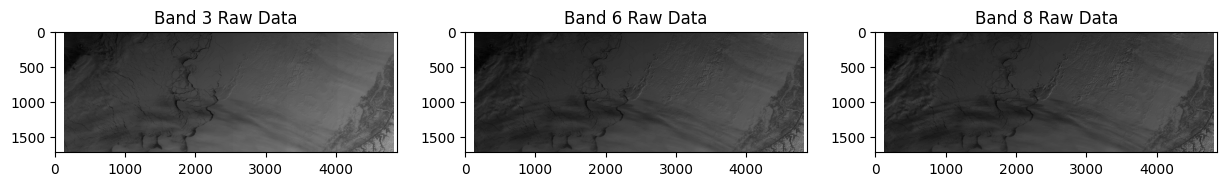

In [4]:
# Visualize the raw data for a few bands
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(bands_data[2], cmap='gray')
axs[0].set_title('Band 3 Raw Data')
axs[1].imshow(bands_data[5], cmap='gray')
axs[1].set_title('Band 6 Raw Data')
axs[2].imshow(bands_data[7], cmap='gray')
axs[2].set_title('Band 8 Raw Data')
plt.show()

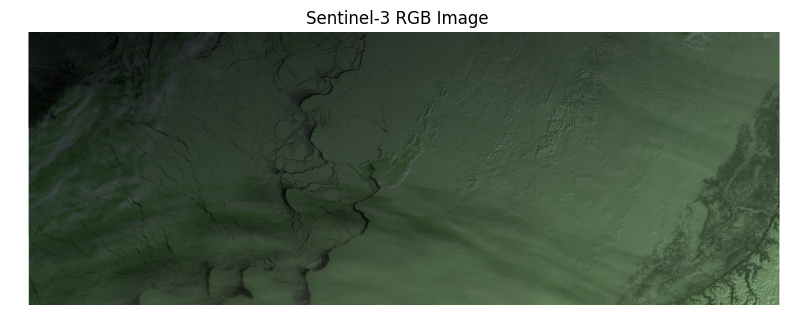

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'stacked_data' is a numpy array with shape (1716, 4865, 21)

# Step 1: Select bands
# For simplicity, let's use bands 3, 6, and 8 for this example
band3 = bands_data[2]
band6 = bands_data[5]
band8 = bands_data[7]

# Step 2: Normalize the bands
def normalize_band(band):
    return (band - np.min(band)) / (np.max(band) - np.min(band))

band3_normalized = normalize_band(band3)
band6_normalized = normalize_band(band6)
band8_normalized = normalize_band(band8)

# Step 3: Create RGB composite image
rgb_image = np.stack([band6_normalized, band3_normalized, band8_normalized], axis=-1)

# Step 4: Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title('Sentinel-3 RGB Image')
plt.axis('off')  # Hide the axis

plt.savefig('/content/drive/MyDrive/GEOL0069/Project/Figures/RGB.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

plt.show()

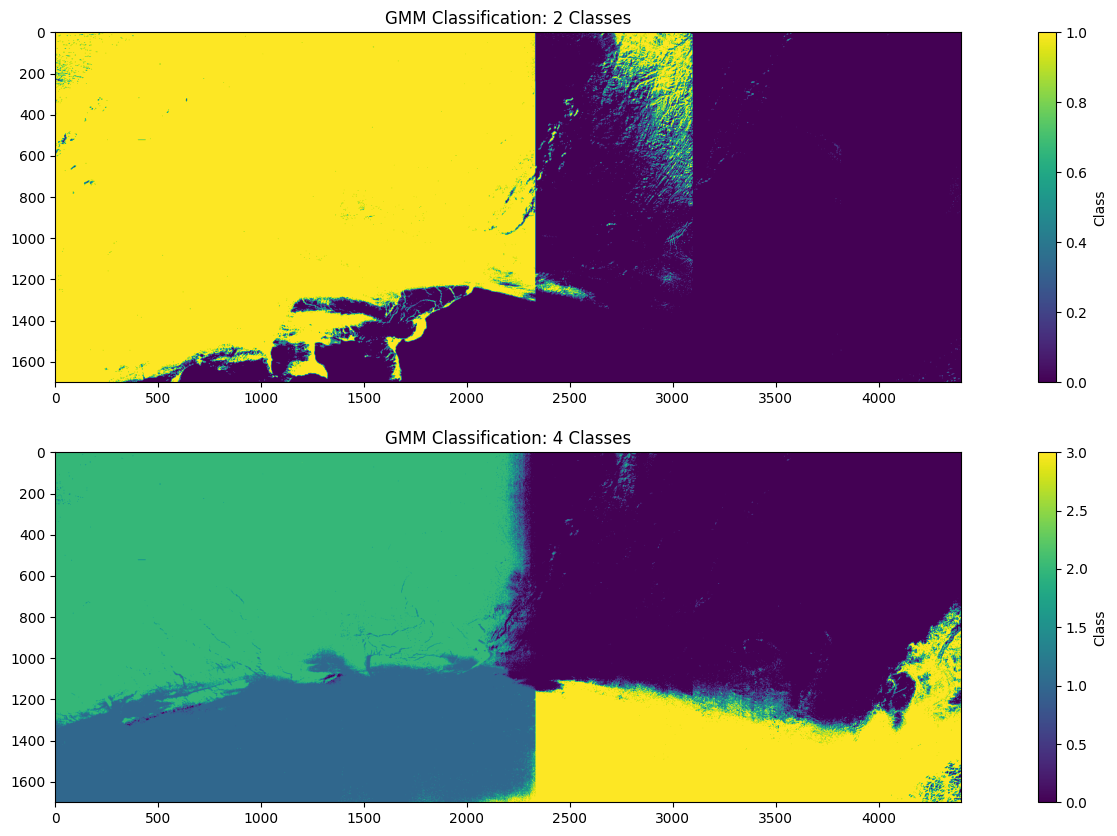

In [26]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Assuming 'stacked_data' is a numpy array with shape (1716, 4865, 21)
# Define the region of interest (ROI) coordinates
# x1, y1, x2, y2 = [350, 800, 550, 1100]
x1, y1, x2, y2 = [200, 0, 4600, 1700]

# Step 1: Extract the ROI from the image
roi = stacked_data[y1:y2, x1:x2, :]

# Step 2: Reshape the ROI to 2D
reshaped_roi = roi.reshape(-1, 21)

# Step 3: Normalize the bands within the ROI
def normalize_band(band):
    band_min = np.min(band)
    band_max = np.max(band)
    if band_max == band_min:
        return np.zeros_like(band)
    norm_band = (band - band_min) / (band_max - band_min)
    return np.clip(norm_band, 0, 1)  # Ensure values are between 0 and 1

normalized_roi = np.array([normalize_band(reshaped_roi[:, i]) for i in range(reshaped_roi.shape[1])]).T

# Step 5: Fit GMM on the reduced ROI data
gmm_2 = GaussianMixture(n_components=2, random_state=42)
gmm_2.fit(normalized_roi)

gmm_4 = GaussianMixture(n_components=4, random_state=42)
gmm_4.fit(normalized_roi)

# Step 6: Predict labels for the ROI data
labels_roi_2 = gmm_2.predict(normalized_roi)
labels_roi_4 = gmm_4.predict(normalized_roi)

# Step 7: Reshape the labels back to the original ROI shape
classified_roi_2 = labels_roi_2.reshape(y2 - y1, x2 - x1)
classified_roi_4 = labels_roi_4.reshape(y2 - y1, x2 - x1)

# Step 8: Plot the classified ROI
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
im1 = axs[0].imshow(classified_roi_2, cmap='viridis')
axs[0].set_title('GMM Classification: 2 Classes')
plt.colorbar(im1, ax=axs[0], label='Class')

im2 = axs[1].imshow(classified_roi_4, cmap='viridis')
axs[1].set_title('GMM Classification: 4 Classes')
plt.colorbar(im2, ax=axs[1], label='Class')

plt.savefig('/content/drive/MyDrive/GEOL0069/Project/Figures/GMM.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

In [19]:
combined_classification = np.where((classified_roi_4 == 1) | (classified_roi_4 == 3), 1, 0)

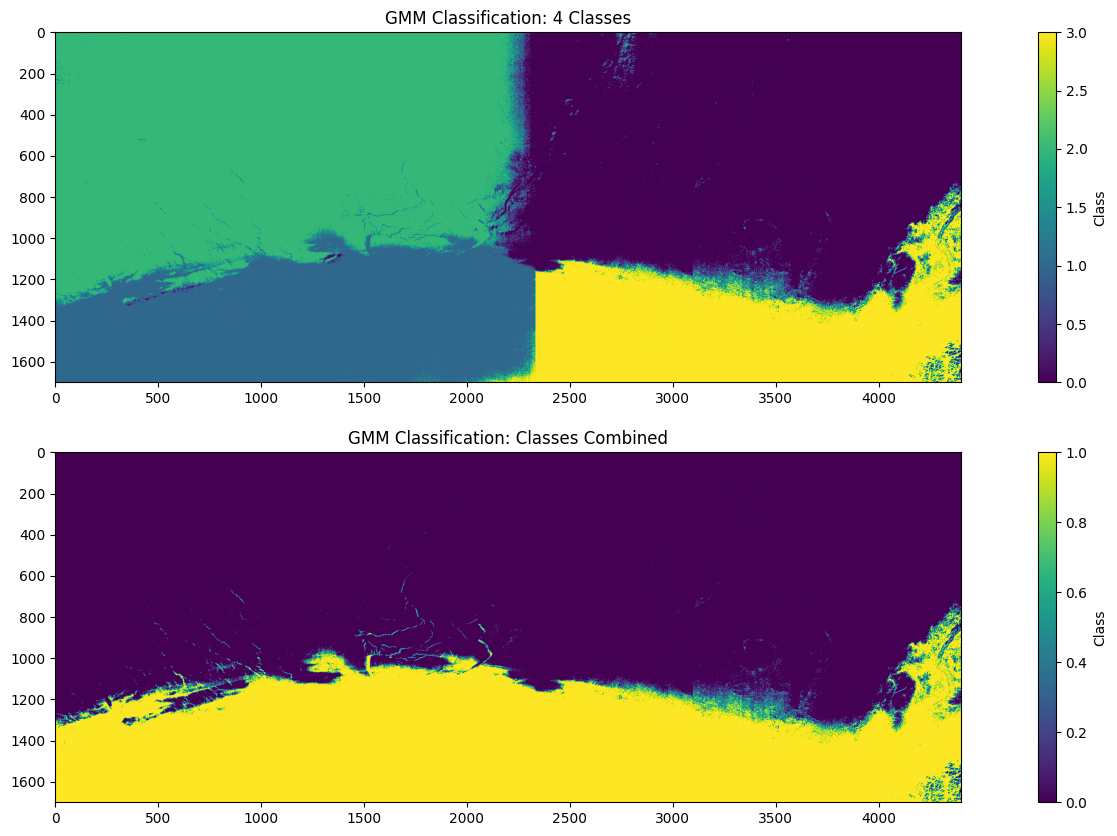

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
im1 = axs[0].imshow(classified_roi_4, cmap='viridis')
axs[0].set_title('GMM Classification: 4 Classes')
plt.colorbar(im1, ax=axs[0], label='Class')

im2 = axs[1].imshow(combined_classification, cmap='viridis')
axs[1].set_title('GMM Classification: Classes Combined')
plt.colorbar(im2, ax=axs[1], label='Class')

plt.savefig('/content/drive/MyDrive/GEOL0069/Project/Figures/GMM_comb.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

In [16]:
# Initially, we examine the quantity of each class present in the dataset
unique, counts = np.unique(classified_roi_4, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2558503, 1: 1349331, 2: 2486205, 3: 1085961}
